In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np


In [97]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [0]:
# Import data
compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

data = datasets.MNIST(root='/root', train=True, transform=compose, download=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)

In [0]:
# Defining the discriminator net, which takes in an input image and gives an output in the range(0,1) to give the 
# probability of whether the image is real or fake

# In this case we use 3 linear layers followed by sigmoid activation 

class DNet(nn.Module):
    def __init__(self):
        super(DNet, self).__init__()
        n_input = 28 * 28
        n_output = 1

        self.layers = nn.Sequential(
            nn.Linear(n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, n_output),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

discriminator = DNet()

In [0]:
# Defining the generator net, which takes in a variable vector and gives an output vector of length 784 with values in the range[-1, 1] 
# which will then be displayed as an image. This works because the input images in the dataset also have pixel values ranging from -1 to 1.

# In this case we use 3 linear layers followed by tanh activation

class GNet(nn.Module):
    def __init__(self):
        super(GNet, self).__init__()
        n_input = 100
        n_output = 28 * 28

        self.layers = nn.Sequential(
            nn.Linear(n_input, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, n_output),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

generator = GNet()

In [0]:
# Functions to convert images to flattened vectors and vice versa
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
# Function to generate the random noise that goes into the generator
def noise(size):
    return Variable(torch.randn(size, 100)).to(device)

In [0]:
# Defining criterion and optimizers

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)


In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):

    n = real_data.size(0)
    optimizer.zero_grad()

    # Train on real data

    real_data = real_data.to(device)
    fake_data = fake_data.to(device)

    prediction_real = discriminator(real_data)
    ones = ones_target(n).to(device)
    loss_real = criterion(prediction_real, ones)
    loss_real.backward()

    prediction_fake = discriminator(fake_data)
    zeros = zeros_target(n).to(device)

    loss_fake = criterion(prediction_fake, zeros)
    loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake, prediction_real, prediction_fake



In [0]:
def train_generator(optimizer, fake_data):

    n = fake_data.size(0)
    optimizer.zero_grad()
    fake_data = fake_data.to(device)

    # Get the prediction on the fake data
    prediction = discriminator(fake_data)

    # If the generator was good, the prediction would be maximum ones, even though the data is all fake
    # which would minimize the following loss

    ones = ones_target(n).to(device)
    loss = criterion(prediction, ones)
    loss.backward()

    optimizer.step()

    return loss

In [0]:
# We will pass the following noise through the model every few iterations to visualize
# how it's performing

num_test_samples = 16
test_noise = noise(num_test_samples)

In [108]:
# This is just for visualization

!pip install tensorboardX

import os
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_loss, g_loss, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_loss, torch.autograd.Variable):
            d_loss = d_loss.data.cpu().numpy()
        if isinstance(g_loss, torch.autograd.Variable):
            g_loss = g_loss.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/d_loss'.format(self.comment), d_loss, step)
        self.writer.add_scalar(
            '{}/g_loss'.format(self.comment), g_loss, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.cpu().numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.cpu().numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_loss, g_loss, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_loss, torch.autograd.Variable):
            d_loss = d_loss.data.cpu().numpy()
        if isinstance(g_loss, torch.autograd.Variable):
            g_loss = g_loss.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_loss, g_loss))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:
discriminator = discriminator.to(device)
generator = generator.to(device)

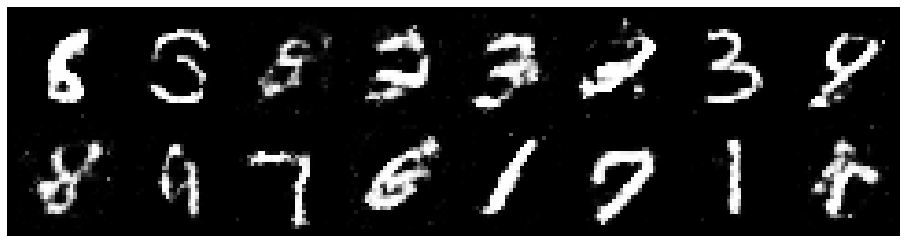

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 1.2477, Generator Loss: 0.9691
D(x): 0.5456, D(G(z)): 0.4183


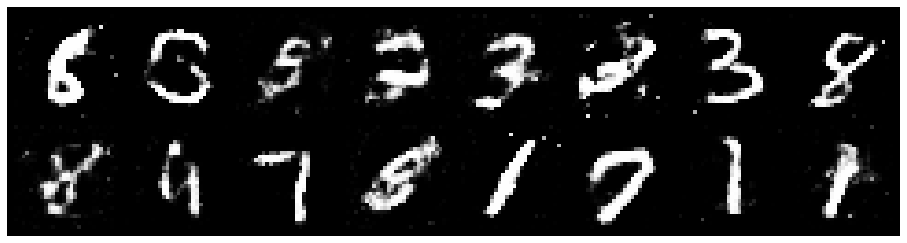

Epoch: [0/50], Batch Num: [100/600]
Discriminator Loss: 1.2372, Generator Loss: 1.0364
D(x): 0.5863, D(G(z)): 0.4219


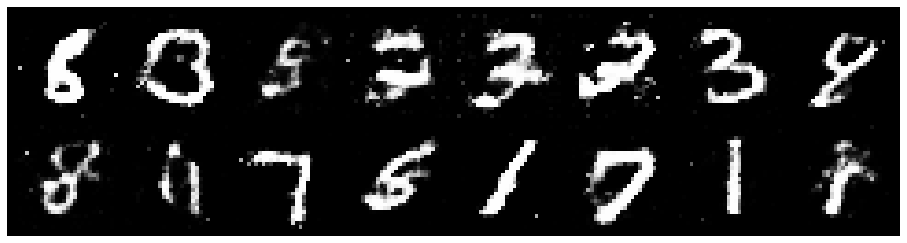

Epoch: [0/50], Batch Num: [200/600]
Discriminator Loss: 1.2599, Generator Loss: 0.8936
D(x): 0.5601, D(G(z)): 0.4362


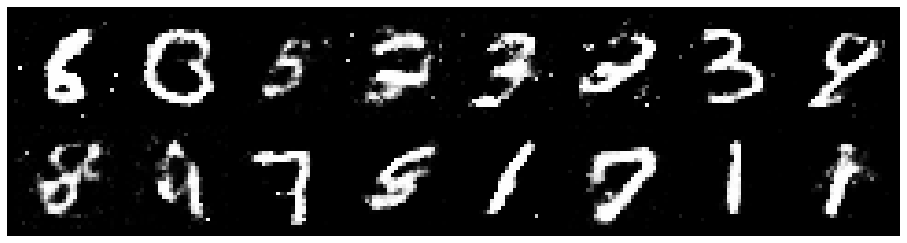

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 1.3377, Generator Loss: 0.7692
D(x): 0.5169, D(G(z)): 0.4623


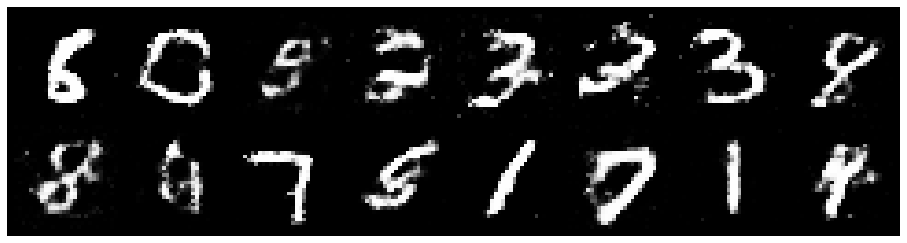

Epoch: [0/50], Batch Num: [400/600]
Discriminator Loss: 1.2253, Generator Loss: 0.8069
D(x): 0.5412, D(G(z)): 0.4131


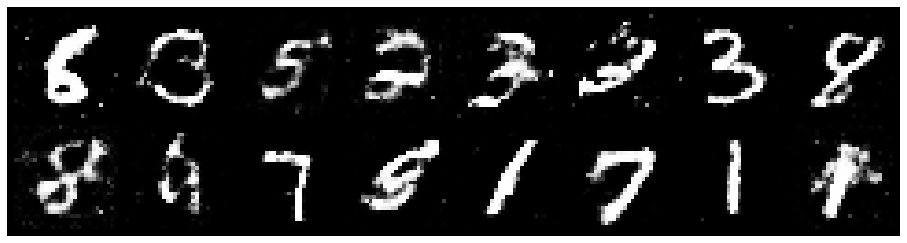

Epoch: [0/50], Batch Num: [500/600]
Discriminator Loss: 1.3106, Generator Loss: 0.8736
D(x): 0.5183, D(G(z)): 0.4399


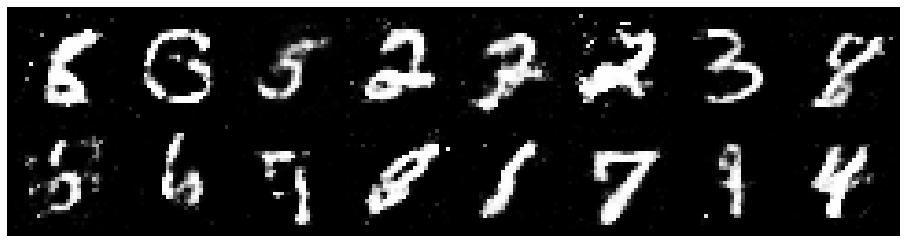

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 1.3105, Generator Loss: 0.7287
D(x): 0.6008, D(G(z)): 0.4999


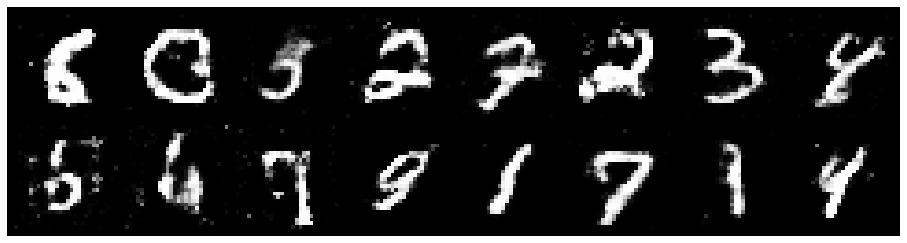

Epoch: [10/50], Batch Num: [100/600]
Discriminator Loss: 1.4195, Generator Loss: 0.7868
D(x): 0.5377, D(G(z)): 0.4914


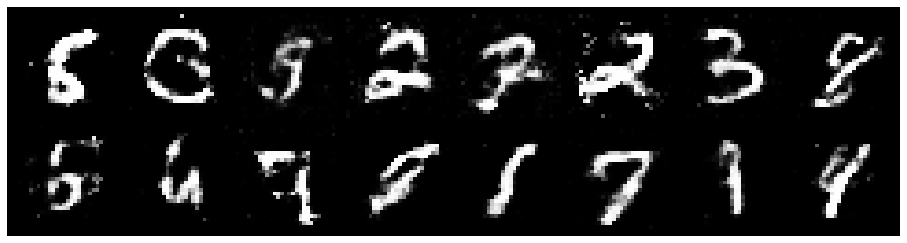

Epoch: [10/50], Batch Num: [200/600]
Discriminator Loss: 1.2849, Generator Loss: 0.8803
D(x): 0.5577, D(G(z)): 0.4291


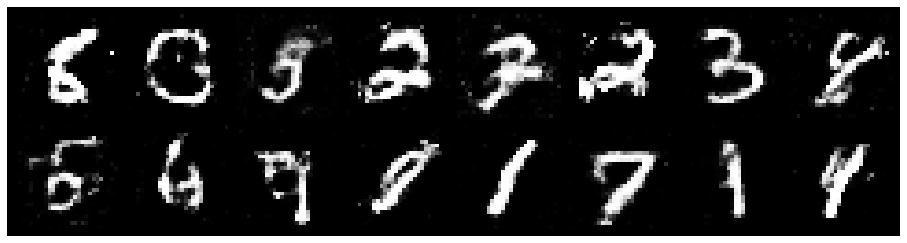

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 1.3246, Generator Loss: 0.8464
D(x): 0.5357, D(G(z)): 0.4520


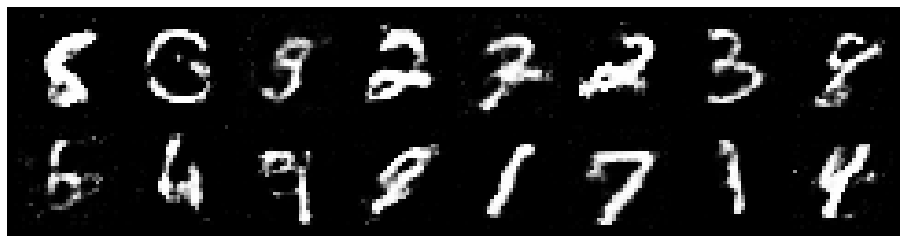

Epoch: [10/50], Batch Num: [400/600]
Discriminator Loss: 1.3798, Generator Loss: 0.8236
D(x): 0.5312, D(G(z)): 0.4545


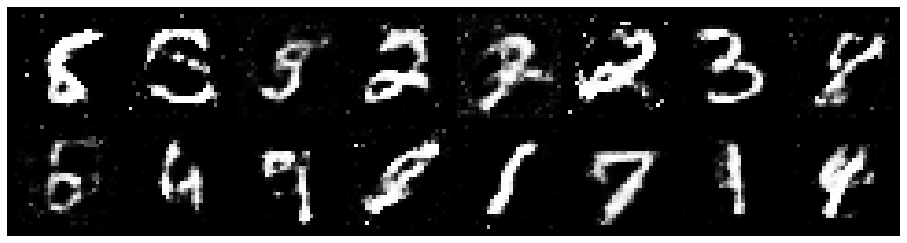

Epoch: [10/50], Batch Num: [500/600]
Discriminator Loss: 1.3699, Generator Loss: 0.9652
D(x): 0.5678, D(G(z)): 0.4783


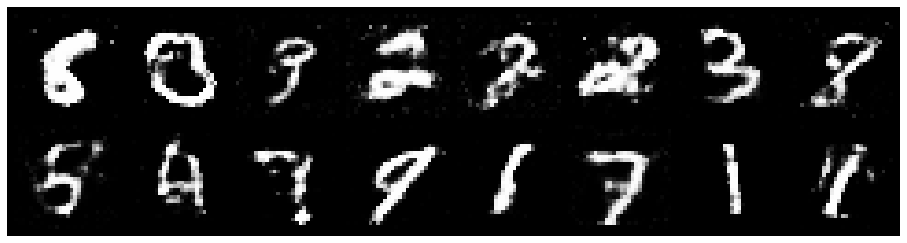

Epoch: [20/50], Batch Num: [0/600]
Discriminator Loss: 1.2208, Generator Loss: 0.8639
D(x): 0.5544, D(G(z)): 0.4311


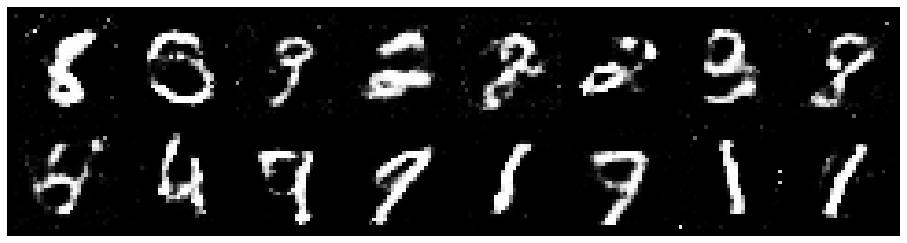

Epoch: [20/50], Batch Num: [100/600]
Discriminator Loss: 1.2686, Generator Loss: 0.9808
D(x): 0.5265, D(G(z)): 0.4112


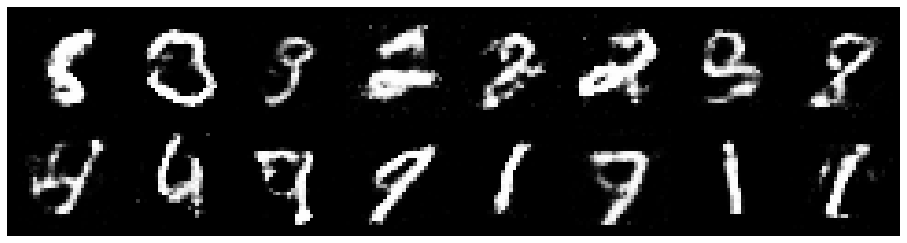

Epoch: [20/50], Batch Num: [200/600]
Discriminator Loss: 1.3342, Generator Loss: 1.0127
D(x): 0.5529, D(G(z)): 0.4507


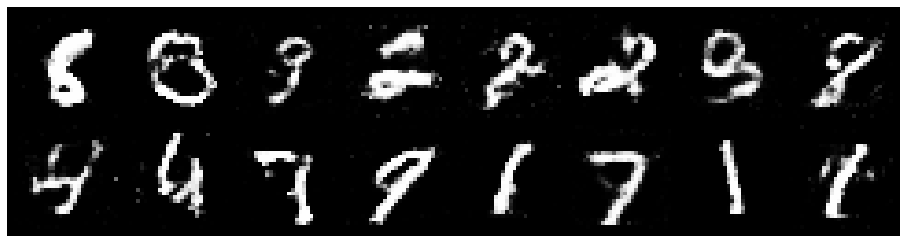

Epoch: [20/50], Batch Num: [300/600]
Discriminator Loss: 1.1725, Generator Loss: 0.9177
D(x): 0.5830, D(G(z)): 0.4132


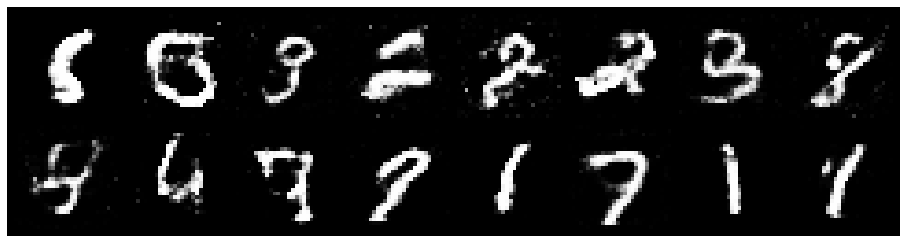

Epoch: [20/50], Batch Num: [400/600]
Discriminator Loss: 1.2660, Generator Loss: 0.9406
D(x): 0.5417, D(G(z)): 0.4201


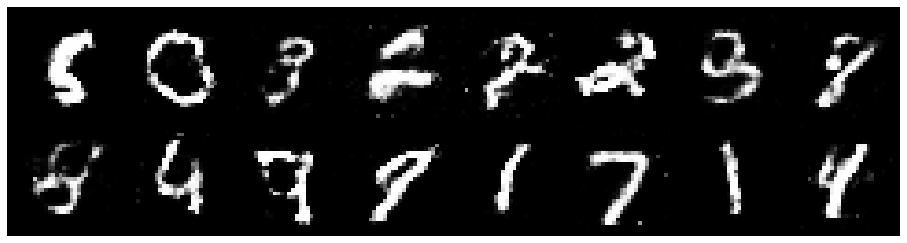

Epoch: [20/50], Batch Num: [500/600]
Discriminator Loss: 1.3847, Generator Loss: 0.8643
D(x): 0.5409, D(G(z)): 0.4788


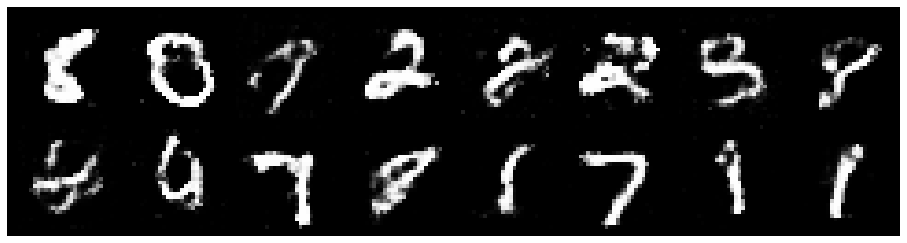

Epoch: [30/50], Batch Num: [0/600]
Discriminator Loss: 1.2278, Generator Loss: 0.9215
D(x): 0.5517, D(G(z)): 0.4122


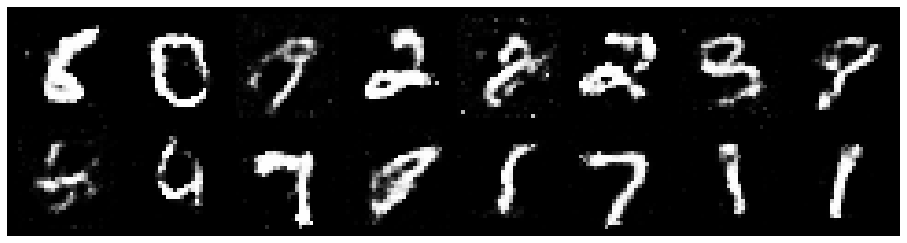

Epoch: [30/50], Batch Num: [100/600]
Discriminator Loss: 1.1945, Generator Loss: 0.9469
D(x): 0.5815, D(G(z)): 0.4380


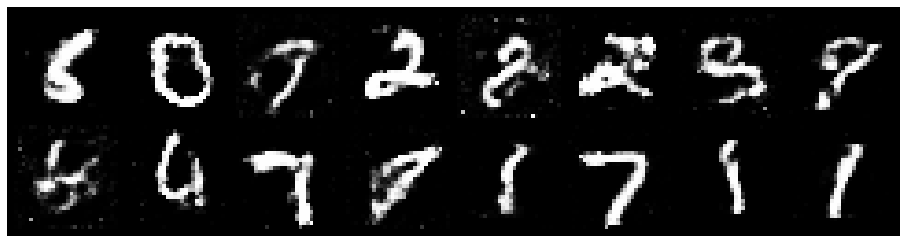

Epoch: [30/50], Batch Num: [200/600]
Discriminator Loss: 1.2481, Generator Loss: 0.8815
D(x): 0.5594, D(G(z)): 0.4369


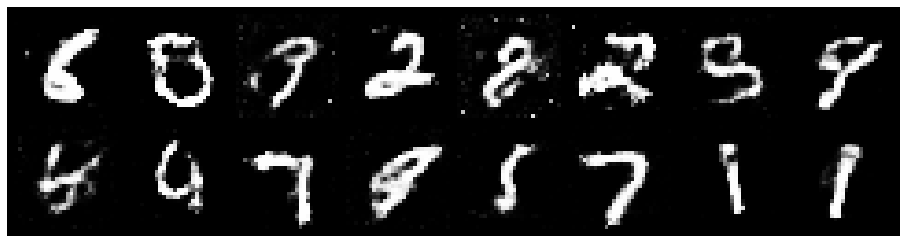

Epoch: [30/50], Batch Num: [300/600]
Discriminator Loss: 1.2369, Generator Loss: 0.9694
D(x): 0.5579, D(G(z)): 0.4213


KeyboardInterrupt: ignored

In [114]:
# Begin training

logger = Logger(model_name='Vanilla_GAN', data_name='MNIST')
n_epochs = 100
print_every = 100

for epoch in range(n_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):

        n = real_batch.size(0)

        # Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        fake_data = generator(noise(n)).detach()

        real_data = real_data.to(device)
        fake_data = fake_data.to(device)

        d_loss, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        fake_data = generator(noise(n))
        fake_data = fake_data.to(device)

        g_loss = train_generator(g_optimizer, fake_data)
        
        # Log the total batch loss
        logger.log(d_loss, g_loss, epoch, n_batch, num_batches)

        # Display progress
        if n_batch % print_every == 0 and epoch % 10 == 0:
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data


            logger.log_images(
                    test_images, num_test_samples, 
                    epoch, n_batch, num_batches
                )
            
            # Display status Logs
            logger.display_status(
                epoch, n_epochs, n_batch, num_batches,
                d_loss, g_loss, d_pred_real, d_pred_fake
            )
        
        if epoch % 10 == 0:
            torch.save(discriminator.state_dict(), 'discriminator.pth')
            torch.save(generator.state_dict(), 'generator.pth')


In [0]:
torch.save(discriminator.state_dict(), 'discriminator.pth')
            torch.save(generator.state_dict(), 'generator.pth')

In [113]:
discriminator.load_state_dict(torch.load('discriminator.pth'))
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>